In [6]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np

from neuralee.dataset import GeneExpressionDataset
from neuralee.embedding import NeuralEE
from neuralee._aux import scatter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

# Dataloading and preprocessing

In [2]:
save_path = 'data/' # you should change the path to your data location.
mnist_train = datasets.MNIST(save_path, train=True, download=True)
mnist_test = datasets.MNIST(save_path, train=False, download=True)

# Experiments
We first apply elastic embedding and NerualEE on 10,000 samples, with perplexity 20, $\lambda$ = 1, noting that we directly use the pixel values, scaled between 0 and 1, as input into embedding algorithms without any further preprocessing. To verify generalizability of NeuralEE, we directly embed the remaining 60,000 samples to visualization space via the learned neural networks.

Compute affinity, perplexity=20.0, on entire dataset
Elastic Embedding, lambda=1, completed in 8.66s, EE loss is 0.243471


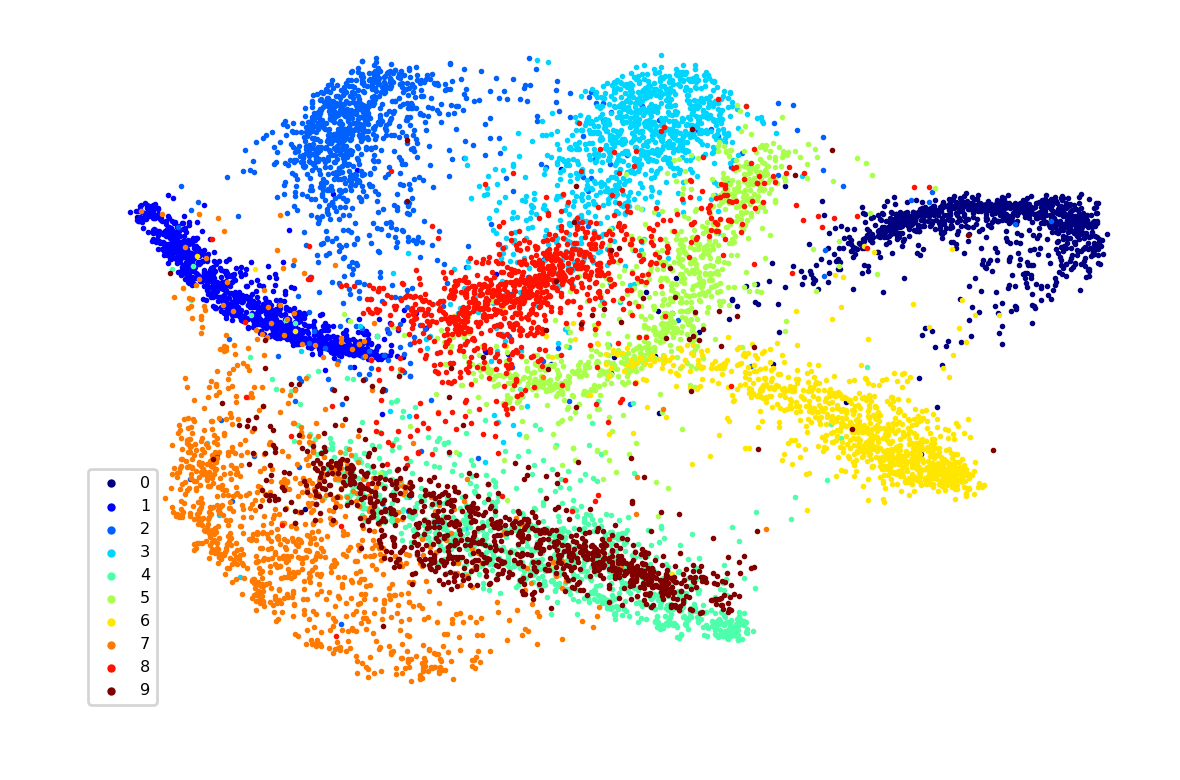

In [3]:
mnist_testset = GeneExpressionDataset(
    Y=mnist_test.data.numpy().reshape(-1, 28 * 28) / np.float32(255), 
    labels=mnist_test.targets.numpy())
mnist_testset.affinity()
NEE = NeuralEE(mnist_testset, lam=1, device=device)
results = NEE.EE() 
scatter(results['X'].numpy(), NEE.labels)

First, we use default two hidden layers neural network as parametric function appied to NeuralEE.

Neural Elastic Embedding, lambda=1, completed in 17.29s, EE loss is 0.251249


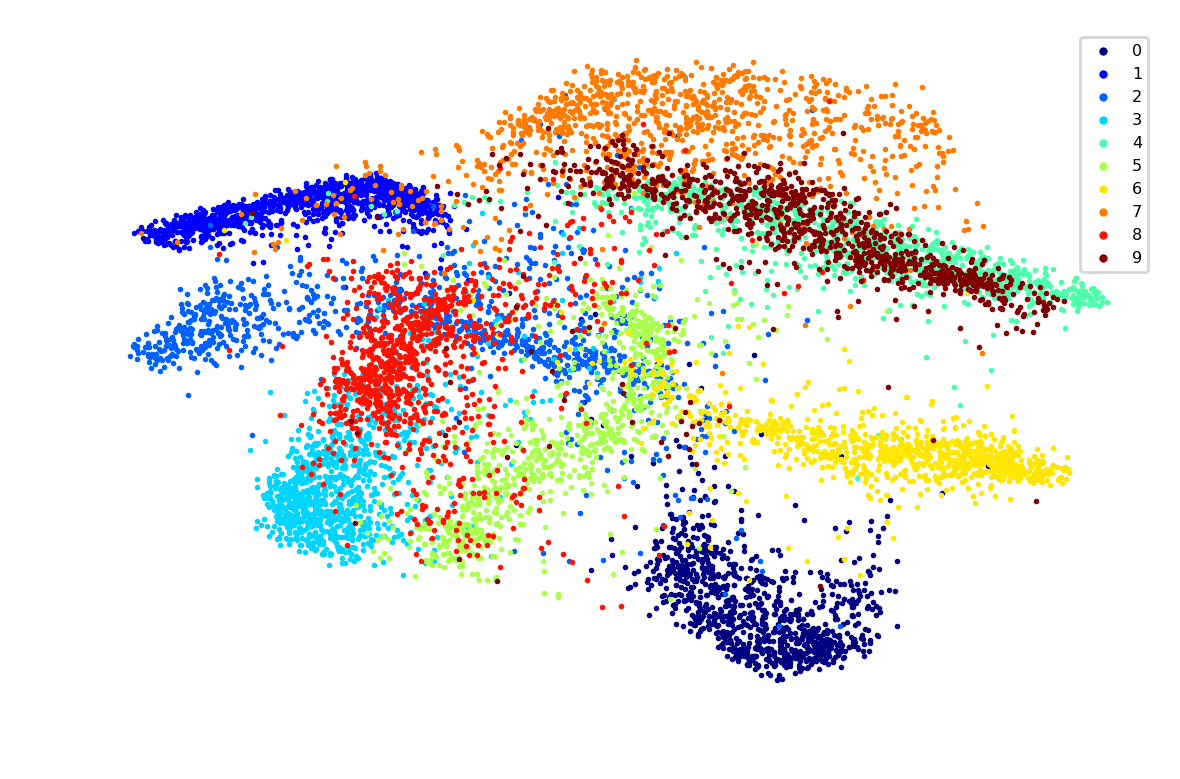

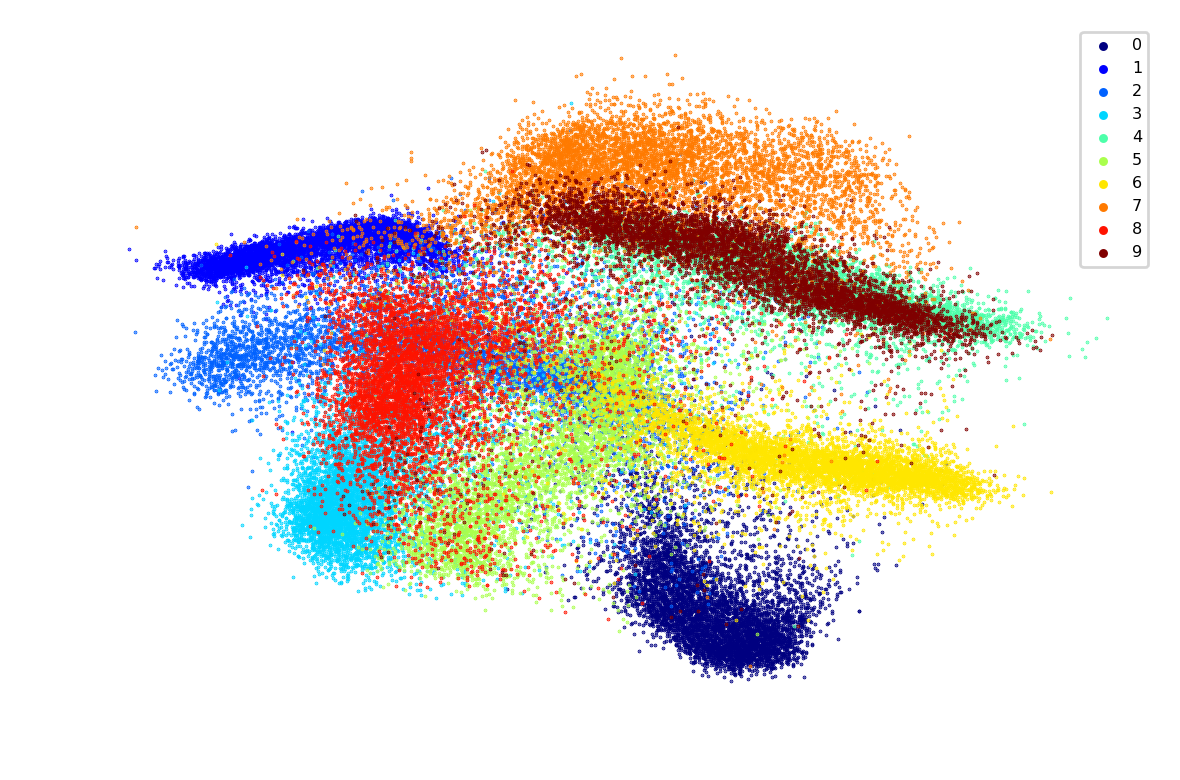

In [4]:
results_Neural = NEE.fine_tune()
scatter(results_Neural['X'].numpy(), NEE.labels)

mnist_trainset = GeneExpressionDataset(
    Y=mnist_train.data.numpy().reshape(-1, 28 * 28) / np.float32(255), 
    labels=mnist_train.targets.numpy())
samples = {'Y': torch.from_numpy(mnist_trainset.Y),
           'labels': mnist_trainset.labels,
           'Wp': None,
           'Wn': None}
results_map = NEE.map(samples, calculate_error=None)
scatter(results_map['X'].numpy(), samples['labels'], s=0.1,
        lg_kwargs={'markerscale': 7, 'fontsize': 'xx-small'})

Comparatively, we also test a convolution neural network.

Neural Elastic Embedding, lambda=1, completed in 74.66s, EE loss is 0.257260


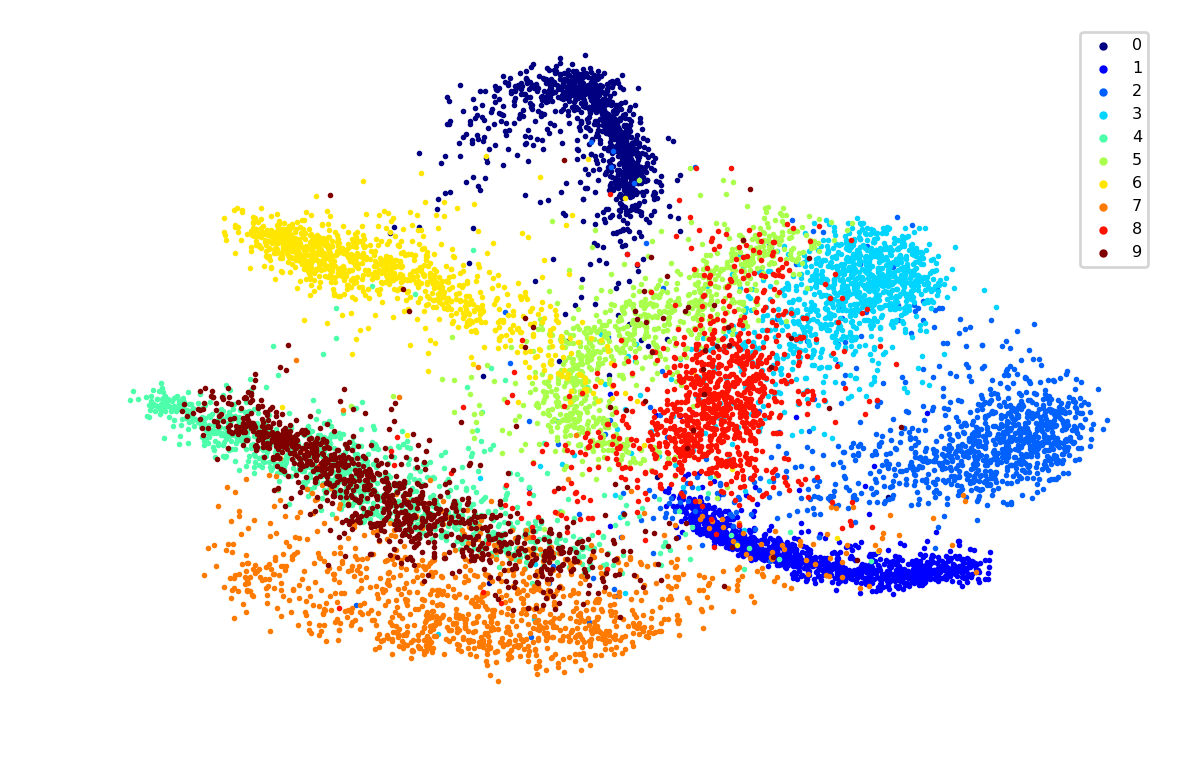

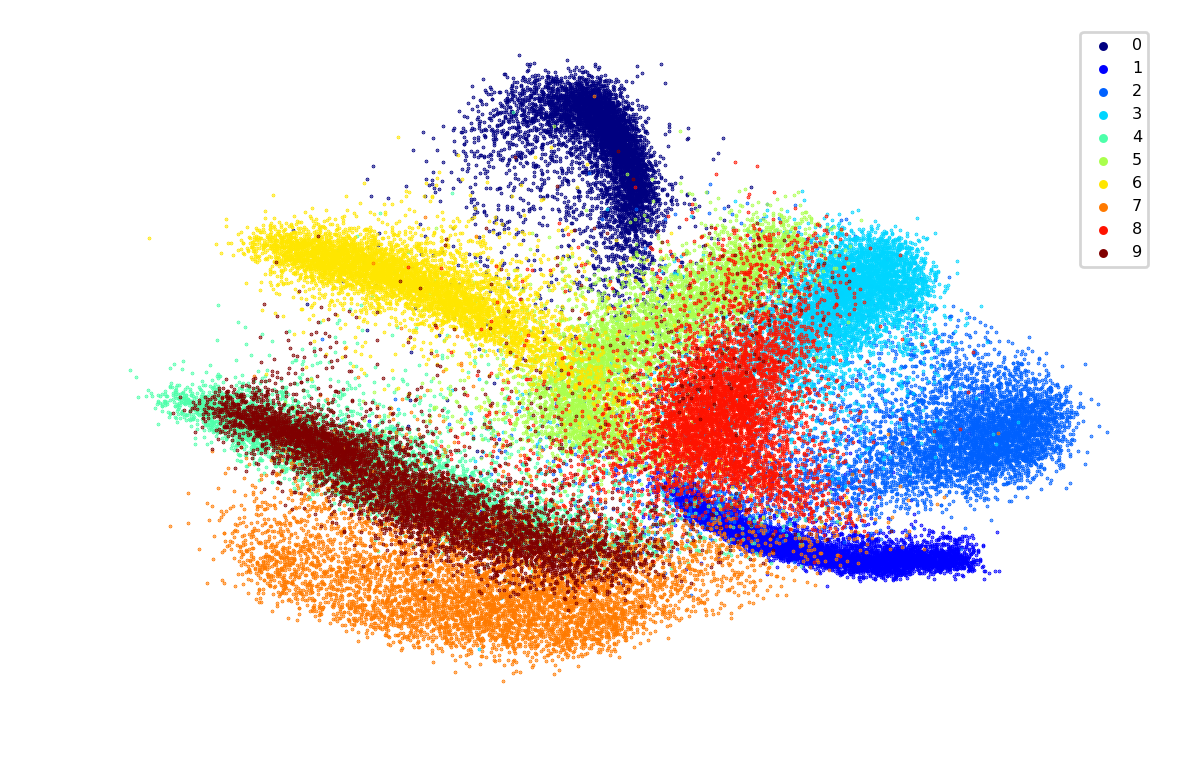

In [5]:
# Define convolution neural network.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 1, 28, 28)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
results_Neural = NEE.fine_tune(net=Net()) # instantiation of convolution neural network as parameter 'net'
scatter(results_Neural['X'].numpy(), NEE.labels)

results_map = NEE.map(samples, calculate_error=None)
scatter(results_map['X'].numpy(), samples['labels'], s=0.1,
        lg_kwargs={'markerscale': 7, 'fontsize': 'xx-small'})